In [2]:
import os
import pprint

from konlpy.tag import Okt
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from random import sample, seed 
from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer
from nltk.tokenize import sent_tokenize

seed(1234)
phoneme_tokenizer = Okt()

DATA_IN_PATH = './data_in/KOR'
save_path = 'bert_ckpt/'

if not os.path.exists(save_path):
    os.makedirs(save_path)
    
BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False).save_pretrained(save_path)
bert_tokenizer = BertWordPieceTokenizer('bert_ckpt/vocab.txt', lowercase=False)

## 데이터 불러오기

In [3]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

3881058/3881058 [==============================] - 1s 0us/step


In [4]:
train_data = json.load(open(train_path))
dev_data = json.load(open(eval_path))

In [5]:
pprint.pprint(train_data['data'][0])

{'paragraphs': [{'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 '
                            '하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 '
                            '산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 '
                            '심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 '
                            '베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 '
                            '서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. '
                            '여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 '
                            '반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 '
                            '교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 '
                            '중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 '
                            '연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 '
                            '지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. '
                            '그 사이에 그는 리엔치와 방황하는 네덜란

## 지문 텍스트 분석

In [6]:
documents = []
for d in train_data['data']:
    documents += [p['context'] for p in d['paragraphs']]
print("전체 텍스트 수: {}".format(len(documents)))

전체 텍스트 수: 9681


In [8]:
train_data.keys()

dict_keys(['version', 'data'])

In [10]:
len(train_data['data'])

1420

In [13]:
train_data['data'][2].keys()

dict_keys(['paragraphs', 'title'])

In [15]:
pprint.pprint(train_data['data'][2])

{'paragraphs': [{'context': '서일본 여객철도 어번 네트워크의 한 축을 구성하고 있다. 오사카 시가지 남부의 철도 교통 '
                            '터미널인 덴노지에서 남쪽으로 철도를 늘려 오사카 남부의 각 도시를 경유하여 와카야마에 '
                            '이르는 노선이다. 한와 선으로부터 서측에 자리한 난카이 전기 철도 본선·공항선과 경합하고 '
                            '있는 것 이외에 신이마미야 역 ~ 모즈 역 간에서는 난카이 전기 철도 고야 선과, 오사카 '
                            '시내에서는 오사카 시 교통국 미도스지·다니마치 선이나 한카이 전기 궤도와도 경합이 '
                            '이루어지고 있다. 야마나카다니 역 ~ 기이 역 간의 오사카부와 와카야마현 간의 경계에는 '
                            '오노야마 고개가 있어 심한 구배 구간이 존재한다. 와카야마 역에서는 기세이 본선과 '
                            '접속하게 되어 기세이 본선을 통해 난키 방면으로 향하는 특급 열차도 운행되고 있다. '
                            '간사이 국제공항이 개통한 1994년 이후에는 간사이 공항선과 연락되어 공항 연락 '
                            '노선으로서의 중요한 역할을 가지게 되었다.',
                 'qas': [{'answers': [{'answer_start': 92, 'text': '와카야마'}],
                          'id': '6464838-0-0',
                          'question': '한와 선은 오사카 덴노지에서 어디까지 가는 노선인가?'},
                         {'answers': [{

### 지문 텍스트 어절 단위 길이 분석

In [32]:
len_docs = []
for d in documents:
    len_docs.append(len(d.split()))
    
print('텍스트 최대 길이: {}'.format(np.max(len_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 75)))

텍스트 최대 길이: 2244
텍스트 최소 길이: 7
텍스트 평균 길이: 114.87
텍스트 길이 표준편차: 47.57
텍스트 중간 길이: 102.0
제 1 사분위 텍스트 길이: 88.0
제 3 사분위 텍스트 길이: 127.0


{'whiskers': [<matplotlib.lines.Line2D at 0x2d728bc4b08>,
 'caps': [<matplotlib.lines.Line2D at 0x2d728bd1848>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d728bc4488>],
 'medians': [<matplotlib.lines.Line2D at 0x2d728bdb448>],
 'fliers': [<matplotlib.lines.Line2D at 0x2d728bd1488>],
 'means': [<matplotlib.lines.Line2D at 0x2d728bdba88>]}

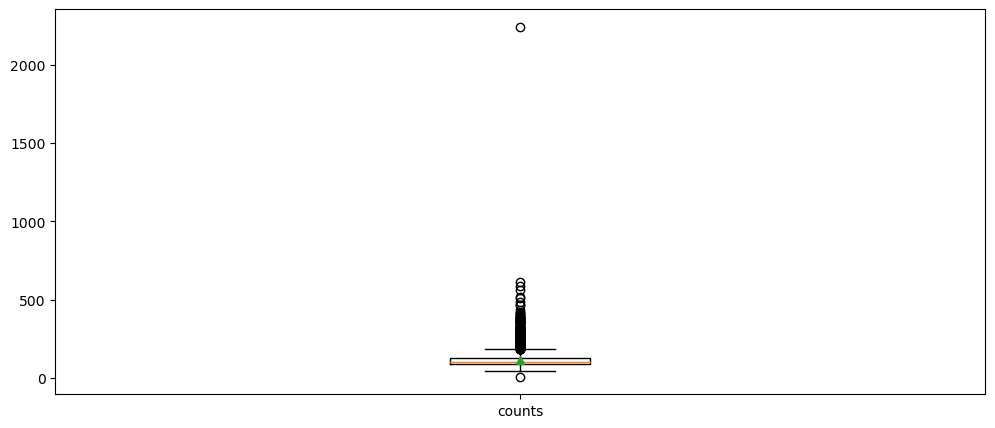

In [33]:
plt.figure(figsize=(12, 5))
plt.boxplot([len_docs],
             labels=['counts'],
             showmeans=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x2d728cdd148>,
 'caps': [<matplotlib.lines.Line2D at 0x2d728cddf88>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d728cd9848>],
 'medians': [<matplotlib.lines.Line2D at 0x2d728ce3b88>],
 'fliers': [<matplotlib.lines.Line2D at 0x2d728cddb88>],
 'means': [<matplotlib.lines.Line2D at 0x2d728ce3648>]}

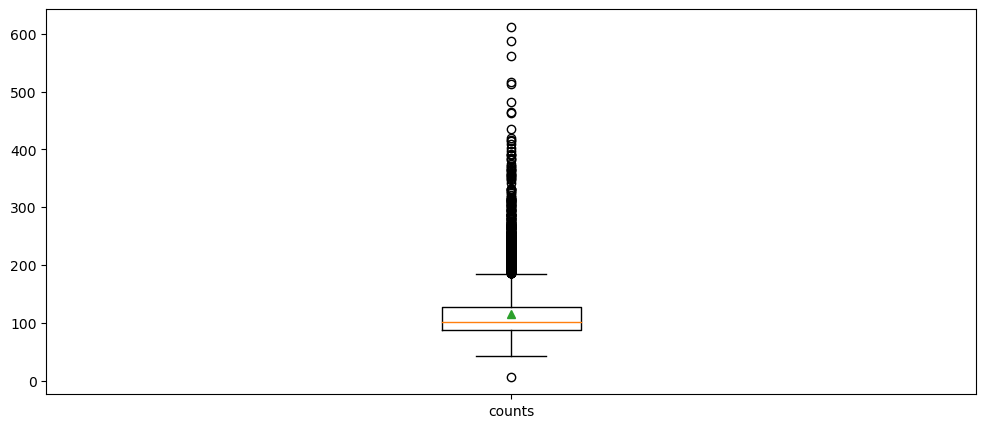

In [34]:
filtered_len_docs = [l for l in len_docs if l < 2000]
# 어절 수 2000 이상 이상치 지문 제거
plt.figure(figsize=(12, 5))

plt.boxplot(filtered_len_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

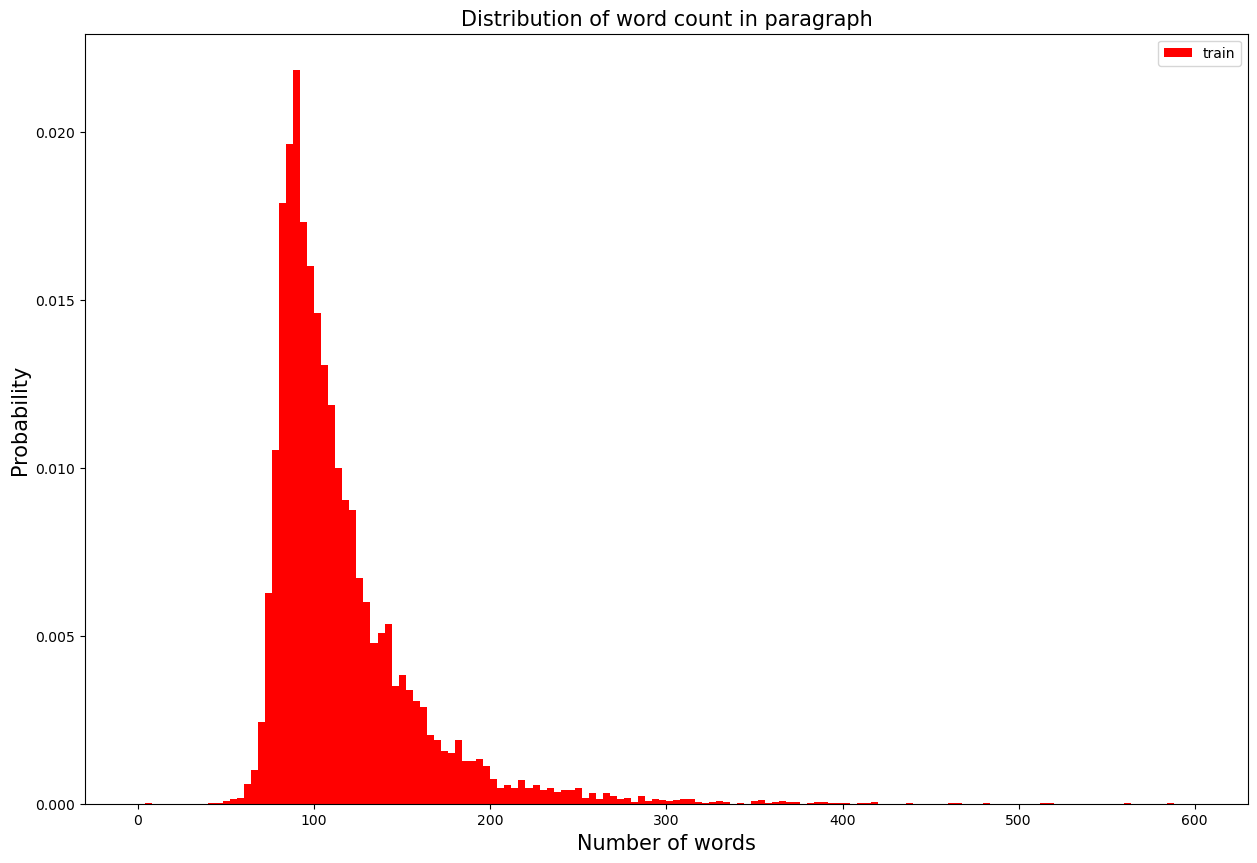

In [35]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_docs, bins=150, range=[0,600], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 지문 텍스트 버트 토크나이저 토큰 길이 분석

In [36]:
len_bert_tokenized_docs = []
for d in documents:
    len_bert_tokenized_docs.append(len(bert_tokenizer.encode(d, add_special_tokens=False).tokens))
    
print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 75)))

텍스트 최대 길이: 6367
텍스트 최소 길이: 120
텍스트 평균 길이: 311.88
텍스트 길이 표준편차: 129.44
텍스트 중간 길이: 279.0
제 1 사분위 텍스트 길이: 239.0
제 3 사분위 텍스트 길이: 344.0


In [40]:
documents[0]

'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'

In [41]:
bert_tokenizer.encode(documents[1], add_special_tokens=False).tokens

['한편',
 '1840',
 '##년부터',
 '바',
 '##그',
 '##너',
 '##와',
 '알',
 '##고',
 '지',
 '##내',
 '##던',
 '리',
 '##스트',
 '##가',
 '잊',
 '##혀',
 '##져',
 '있던',
 '1',
 '##악',
 '##장을',
 '부',
 '##활',
 '##시',
 '##켜',
 '1852',
 '##년에',
 '바',
 '##이',
 '##마',
 '##르',
 '##에서',
 '연',
 '##주',
 '##했다',
 '.',
 '이',
 '##것을',
 '계',
 '##기로',
 '바',
 '##그',
 '##너',
 '##도',
 '이',
 '작',
 '##품',
 '##에',
 '다시',
 '관',
 '##심을',
 '갖',
 '##게',
 '되었고',
 ',',
 '그',
 '해',
 '9월',
 '##에는',
 '총',
 '##보',
 '##의',
 '반',
 '##환',
 '##을',
 '요',
 '##구',
 '##하여',
 '이를',
 '서',
 '##곡',
 '##으로',
 '간',
 '##추',
 '##린',
 '다음',
 '수',
 '##정을',
 '했',
 '##고',
 '브',
 '##라',
 '##이트',
 '##코',
 '##프',
 '##흐',
 '&',
 '헤',
 '##르',
 '##텔',
 '출',
 '##판',
 '##사에',
 '##서',
 '출',
 '##판',
 '##할',
 '개',
 '##정',
 '##판',
 '##도',
 '준',
 '##비',
 '##했다',
 '.',
 '1853',
 '##년',
 '5월',
 '##에는',
 '리',
 '##스트',
 '##가',
 '이',
 '작',
 '##품',
 '##이',
 '수',
 '##정되었다',
 '##는',
 '것을',
 '인',
 '##정',
 '##했지만',
 ',',
 '끝',
 '##내',
 '바',
 '##그',
 '##너',
 '##의',
 '출',
 '##판',
 '계',

In [46]:
len(bert_tokenizer.encode(documents[1], add_special_tokens=False).tokens)

300

In [49]:
bert_tokenizer.encode(documents[1], add_special_tokens=False)

Encoding(num_tokens=300, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [47]:
len(tokenizer.tokenize(documents[1]))

300

In [48]:
tokenizer.tokenize(documents[1]) == bert_tokenizer.encode(documents[1], add_special_tokens=False).tokens

True

In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

tokenizer.tokenize(documents[1])

['한편',
 '1840',
 '##년부터',
 '바',
 '##그',
 '##너',
 '##와',
 '알',
 '##고',
 '지',
 '##내',
 '##던',
 '리',
 '##스트',
 '##가',
 '잊',
 '##혀',
 '##져',
 '있던',
 '1',
 '##악',
 '##장을',
 '부',
 '##활',
 '##시',
 '##켜',
 '1852',
 '##년에',
 '바',
 '##이',
 '##마',
 '##르',
 '##에서',
 '연',
 '##주',
 '##했다',
 '.',
 '이',
 '##것을',
 '계',
 '##기로',
 '바',
 '##그',
 '##너',
 '##도',
 '이',
 '작',
 '##품',
 '##에',
 '다시',
 '관',
 '##심을',
 '갖',
 '##게',
 '되었고',
 ',',
 '그',
 '해',
 '9월',
 '##에는',
 '총',
 '##보',
 '##의',
 '반',
 '##환',
 '##을',
 '요',
 '##구',
 '##하여',
 '이를',
 '서',
 '##곡',
 '##으로',
 '간',
 '##추',
 '##린',
 '다음',
 '수',
 '##정을',
 '했',
 '##고',
 '브',
 '##라',
 '##이트',
 '##코',
 '##프',
 '##흐',
 '&',
 '헤',
 '##르',
 '##텔',
 '출',
 '##판',
 '##사에',
 '##서',
 '출',
 '##판',
 '##할',
 '개',
 '##정',
 '##판',
 '##도',
 '준',
 '##비',
 '##했다',
 '.',
 '1853',
 '##년',
 '5월',
 '##에는',
 '리',
 '##스트',
 '##가',
 '이',
 '작',
 '##품',
 '##이',
 '수',
 '##정되었다',
 '##는',
 '것을',
 '인',
 '##정',
 '##했지만',
 ',',
 '끝',
 '##내',
 '바',
 '##그',
 '##너',
 '##의',
 '출',
 '##판',
 '계',

{'whiskers': [<matplotlib.lines.Line2D at 0x2d72950ed88>,
 'caps': [<matplotlib.lines.Line2D at 0x2d729514408>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d72950e8c8>],
 'medians': [<matplotlib.lines.Line2D at 0x2d72951a148>],
 'fliers': [<matplotlib.lines.Line2D at 0x2d729514508>],
 'means': [<matplotlib.lines.Line2D at 0x2d729514d48>]}

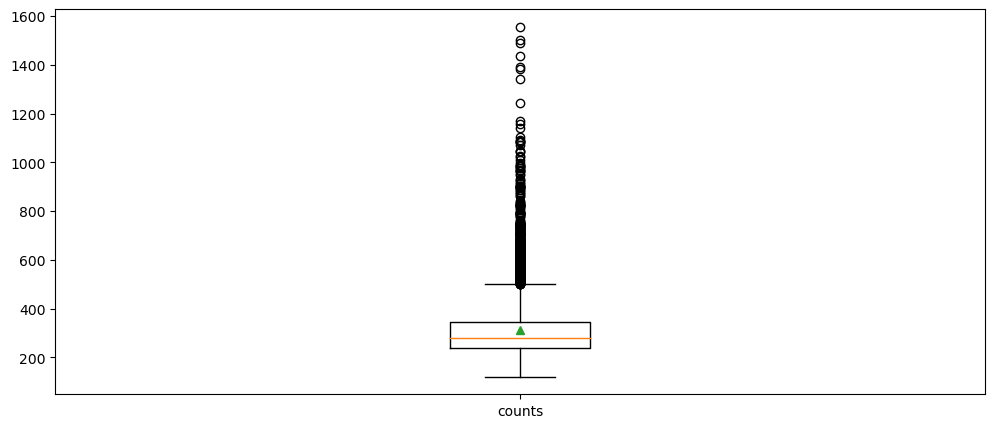

In [37]:
filtered_len_bert_tokenized_docs = [l for l in len_bert_tokenized_docs if l < 3000]
# 버트 토큰수 3000개 이상 이상치 지문 제거
plt.figure(figsize=(12, 5))

plt.boxplot(filtered_len_bert_tokenized_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

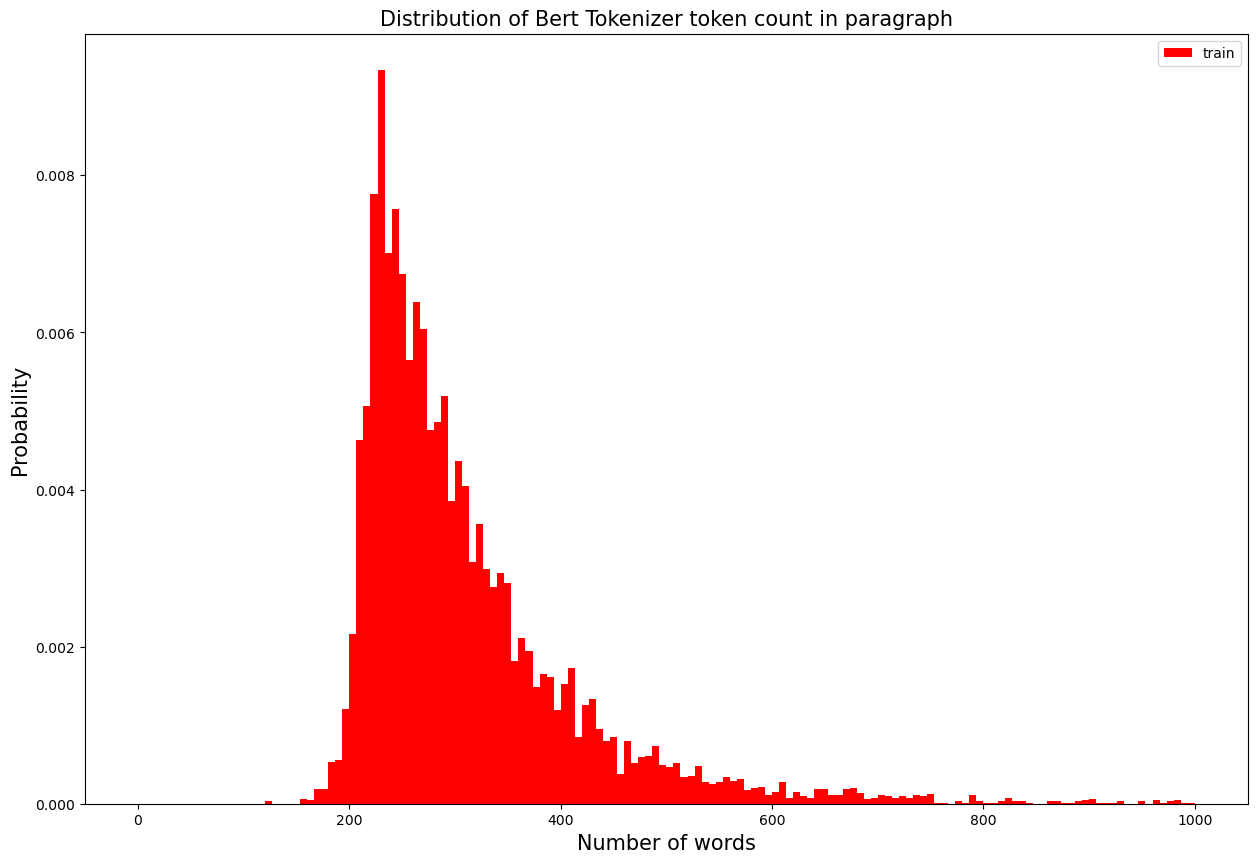

In [38]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_bert_tokenized_docs, bins=150, range=[0,1000], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

## 지문 텍스트 어휘 빈도 분석

### 어절 토큰 기준

In [50]:
sentences = []
for d in documents:
    sentences += sent_tokenize(d)

print('전체 문장 수: {}'.format(len(sentences)))
sampled_docs = sample(sentences, 20000)

전체 문장 수: 67884


In [51]:
sentences[0]

'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다.'

(-0.5, 799.5, 599.5, -0.5)

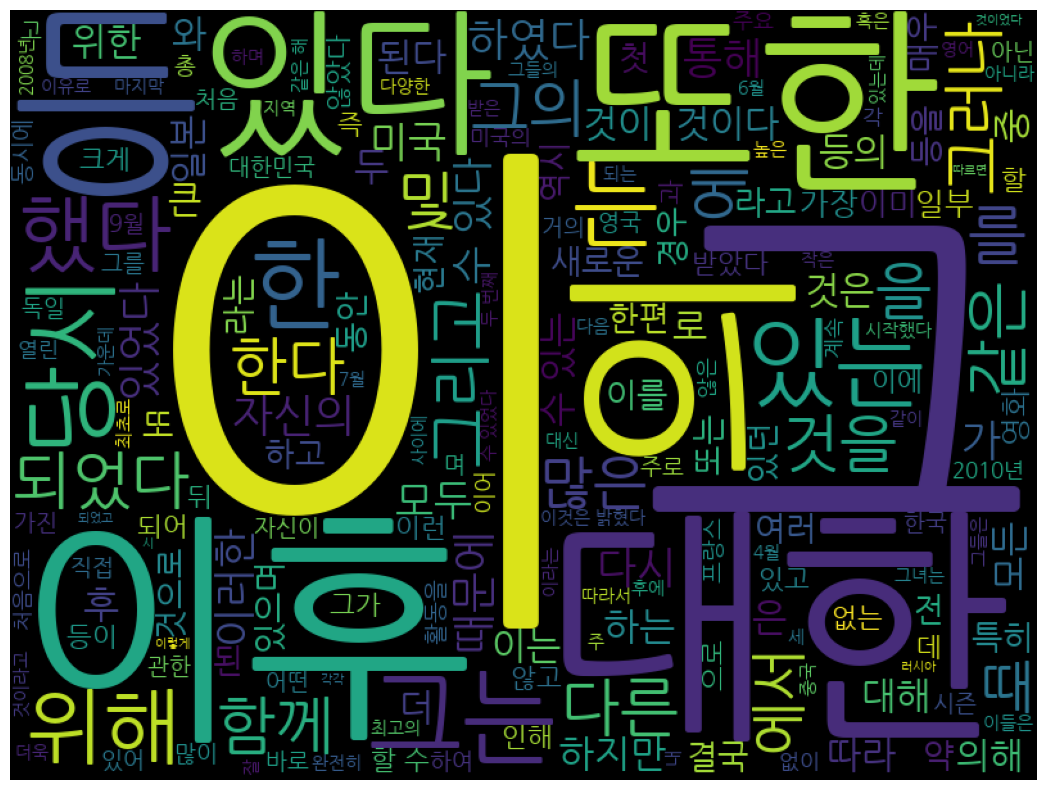

In [52]:
font_path = os.path.join(DATA_IN_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

### 명사 토큰 기준

(-0.5, 799.5, 599.5, -0.5)

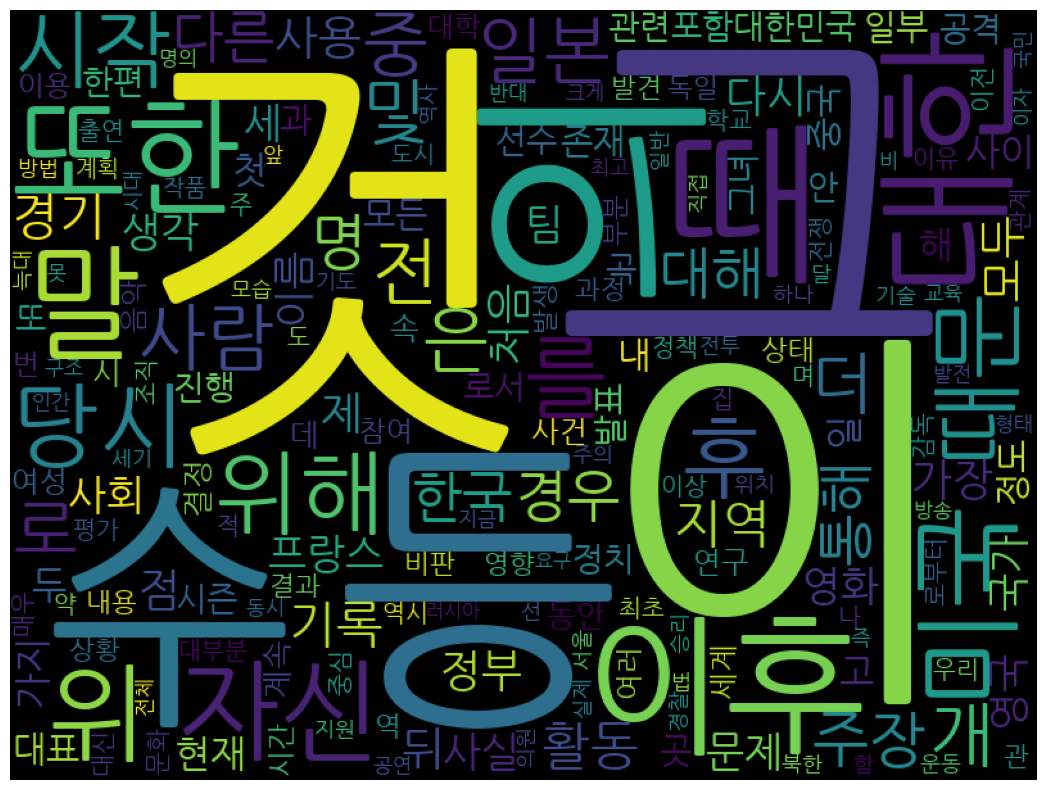

In [53]:
noun_extracted_docs = []
for d in sampled_docs:
    noun_extracted_docs += phoneme_tokenizer.nouns(d)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [54]:
Okt().nouns("안녕하세요, 제 이름은 문진현입니다.")

['제', '이름', '문진', '현']

## 질문 데이터 분석

In [55]:
questions = []
for d in train_data['data']:
    qas = [p['qas'] for p in d['paragraphs']]
    for c in qas:
        questions += [q['question'] for q in c]
    
print('전체 질문 수: {}'.format(len(questions)))

전체 질문 수: 60407


### 질문 텍스트 어절 토큰 길이 분석

텍스트 최대 길이: 35
텍스트 최소 길이: 1
텍스트 평균 길이: 7.85
텍스트 길이 표준편차: 3.09
텍스트 중간 길이: 7.0
제 1 사분위 텍스트 길이: 6.0
제 3 사분위 텍스트 길이: 10.0


Text(0, 0.5, 'Probability')

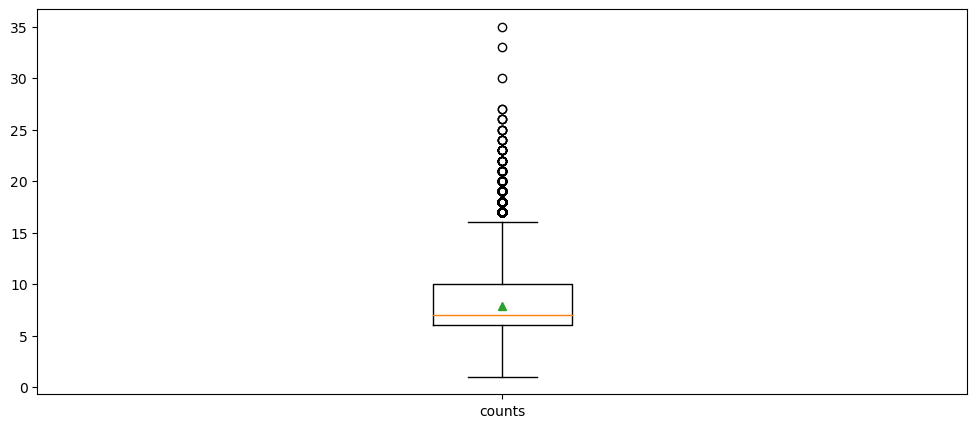

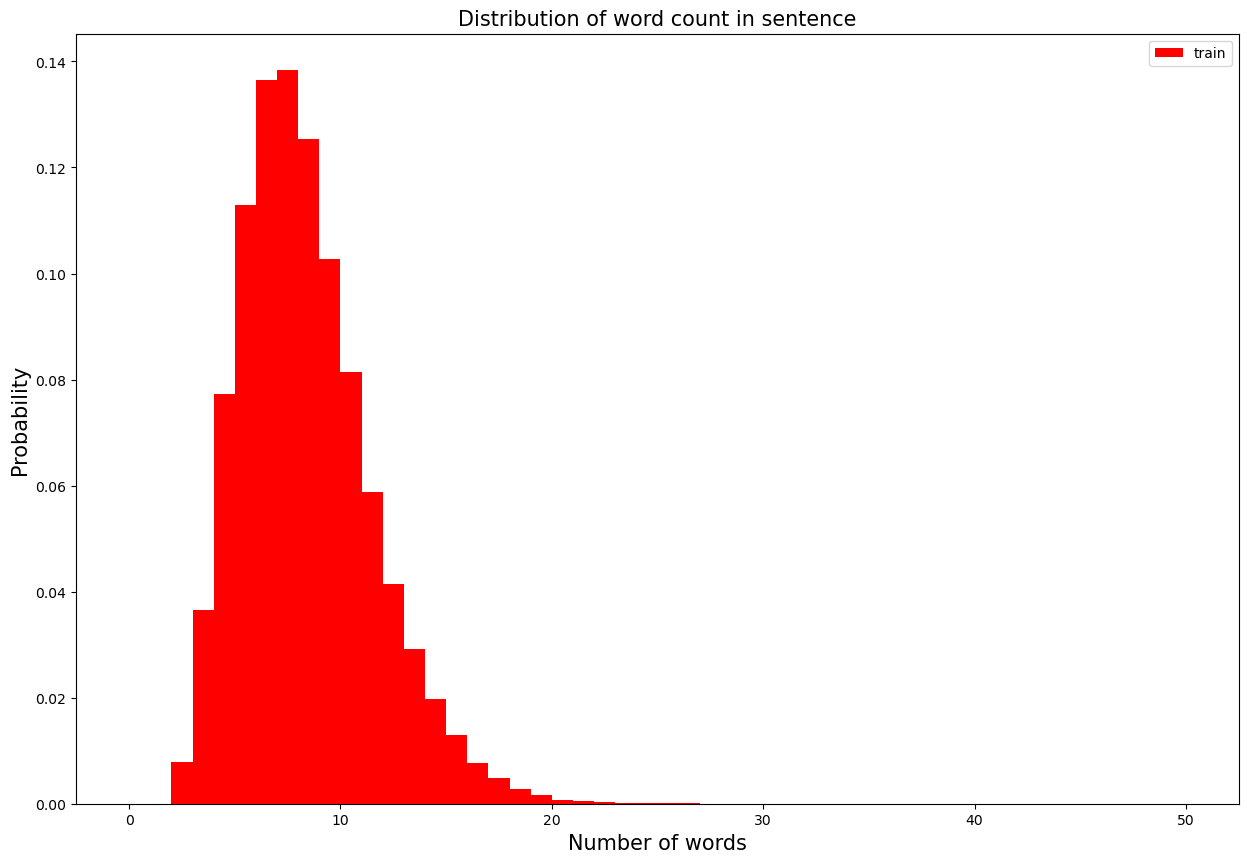

In [56]:
len_qs = []
for q in questions:
    len_qs.append(len(q.split()))
    
print('텍스트 최대 길이: {}'.format(np.max(len_qs)))
print('텍스트 최소 길이: {}'.format(np.min(len_qs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_qs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_qs)))
print('텍스트 중간 길이: {}'.format(np.median(len_qs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 75)))

plt.figure(figsize=(12, 5))
plt.boxplot([len_qs],
             labels=['counts'],
             showmeans=True)

plt.figure(figsize=(15, 10))
plt.hist(len_qs, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 질문 텍스트 버트 토크나이저 토큰 길이 분석

텍스트 최대 길이: 91
텍스트 최소 길이: 4
텍스트 평균 길이: 22.07
텍스트 길이 표준편차: 7.96
텍스트 중간 길이: 21.0
제 1 사분위 텍스트 길이: 16.0
제 3 사분위 텍스트 길이: 27.0


Text(0, 0.5, 'Probability')

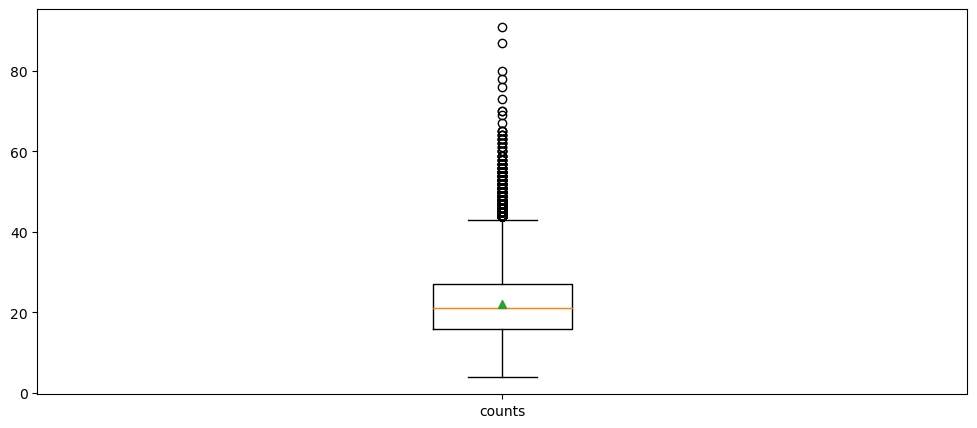

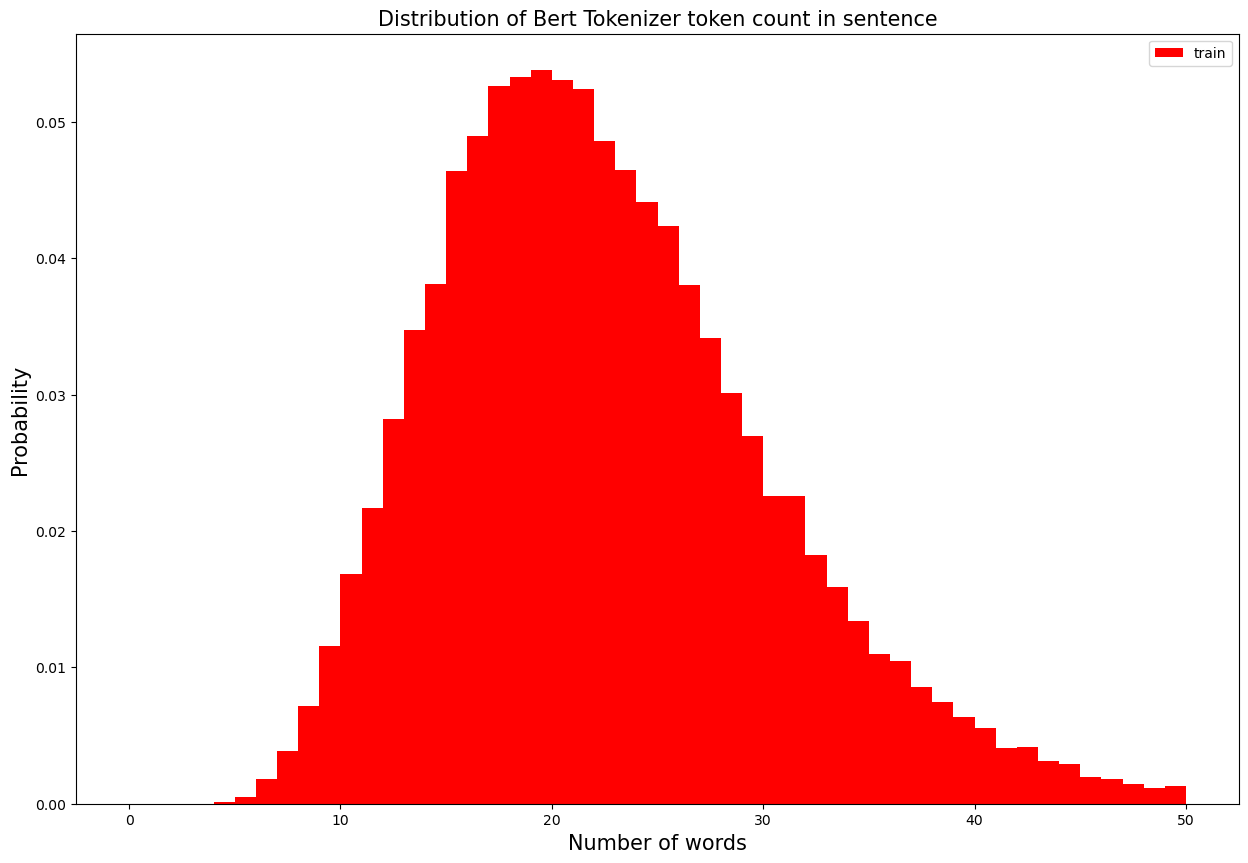

In [57]:
len_bert_tokenized_q = []
for q in questions:
    len_bert_tokenized_q.append(len(bert_tokenizer.encode(q, add_special_tokens=False).tokens))
    
print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_q)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_q)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_q)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_q)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_q)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 75)))

plt.figure(figsize=(12, 5))
plt.boxplot([len_bert_tokenized_q],
             labels=['counts'],
             showmeans=True)


plt.figure(figsize=(15, 10))
plt.hist(len_bert_tokenized_q, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

## 질문 텍스트 어휘 빈도 분석

### 어절 토큰 기준

(-0.5, 799.5, 599.5, -0.5)

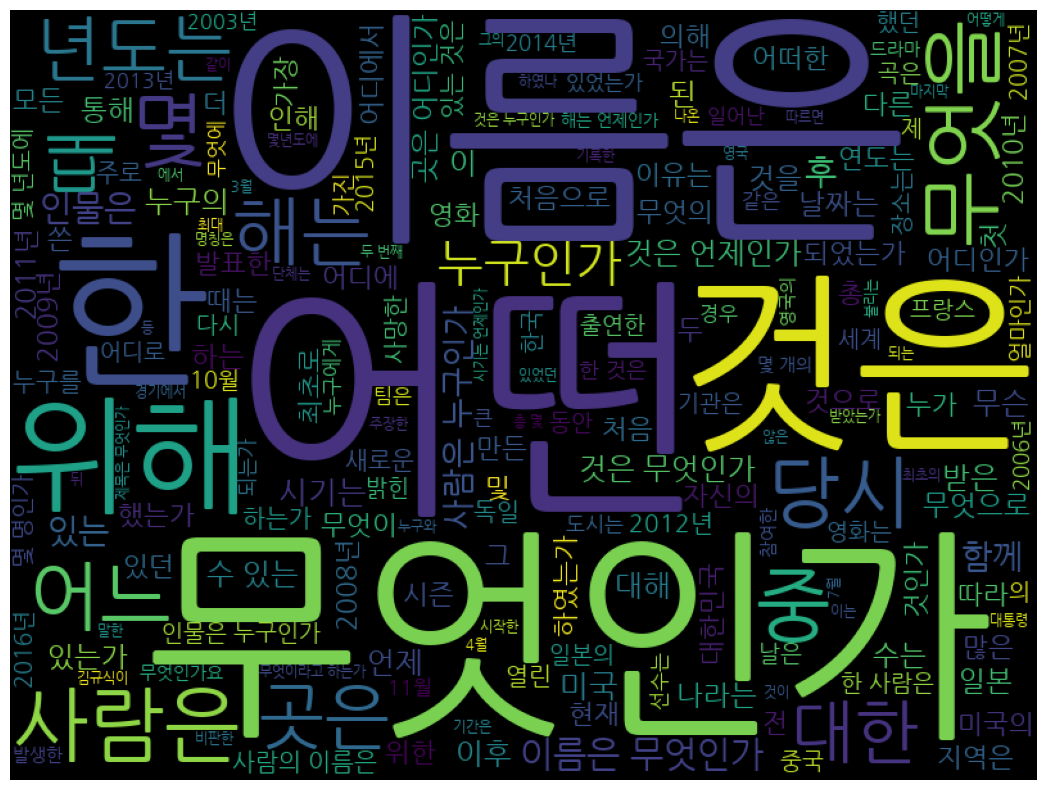

In [58]:
sampled_questions = sample(questions, 20000)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_questions))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

### 명사 토큰 기준

(-0.5, 799.5, 599.5, -0.5)

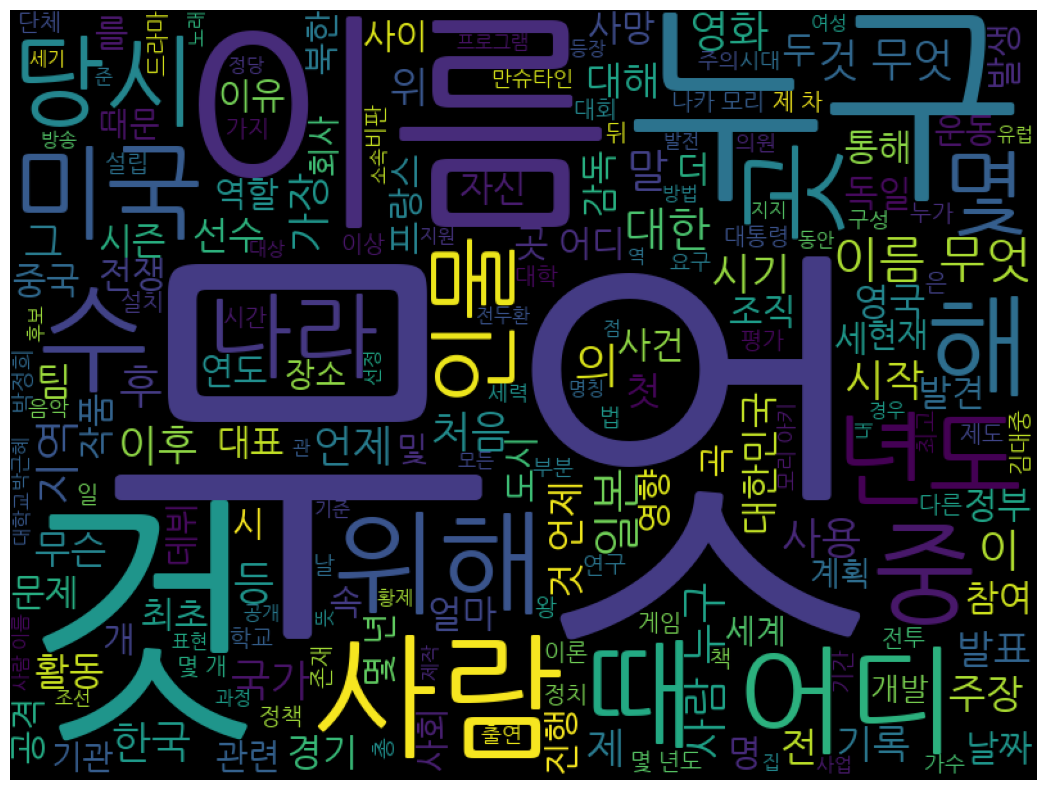

In [59]:
noun_extracted_qs = []
for q in sampled_questions:
    noun_extracted_qs += phoneme_tokenizer.nouns(q)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_qs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')